In [1]:
!pip install --upgrade pip
!pip install "tensorflow[and-cuda]"
!pip install pandas
!pip install visualkeras
 

In [2]:
!pip install scikit-learn

In [1]:
import tensorflow as tf
import absl.logging
import os

# Define o nível de log do TensorFlow para 3 (erro)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importa o módulo de log do TensorFlow e define o nível de log para erro
absl.logging.set_verbosity(absl.logging.ERROR)


stderr = os.dup(2)  # Cria uma cópia do descritor de arquivo 2 (stderr)
os.close(2)  # Fecha o descritor de arquivo 2

# Abre o descritor de arquivo 2 e o redireciona para /dev/null
os.open(os.devnull, os.O_RDWR)


tf.get_logger().setLevel('ERROR')
print(tf.config.list_physical_devices('GPU'))


# os.dup2(stderr, 2) # Restaura o stderr original

2024-11-09 19:34:49.814210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 19:34:49.909941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 19:34:49.932469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 19:34:50.005340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 19:34:51.245136: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Configurações
BATCH_SIZE = 16
EPOCHS = 1000
IMAGE_SIZE = 64
MAIN_DIR = '_recortado'
CHANNELS = 31
LAYER_SIZE = 12

In [3]:
import string
import datetime

# Função para remover números de uma string


def remove_numbers(s):
    return s.translate(str.maketrans('', '', string.digits))

In [4]:
folder_to_label = {}
id_to_label = {}

# Carrega as pastas
folders = sorted(os.listdir(MAIN_DIR))

# Nos temos um conjunto de categorias, cada categoria possui 5 amostras
# Entao uma categoria tem 5 pastas. Exemplo (ardidos1, ardidos2, ardidos3, ardidos4 e ardidos5)
# Removemos o numero no do final do nome da pasta e adicionamos ao dicionario

i = -1
for folder in folders:
    # Pega o nome da pasta remove o numero e adiciona ao dicionario
    # O nome da pasta eh o label
    keys = list(map(lambda x: remove_numbers(x), folder_to_label.keys()))

    if not remove_numbers(folder) in keys:
        i += 1
        folder_to_label[folder] = i
    else:
        folder_to_label[folder] = i


# Cria um dicionario que mapeia o id para o label
for key, value in folder_to_label.items():
    id_to_label[value] = remove_numbers(key)

# print(folder_to_label)

print("Categorias:")
for key, values in id_to_label.items():
    print(f'\t{key}: {values}')

Categorias:
	0: ardidos
	1: bandinhas
	2: chochos
	3: fermentados
	4: imaturos
	5: mofados
	6: purpuras
	7: queimados
	8: soja
	9: soja_b


In [5]:
len(id_to_label)

10

In [6]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import string
import random

# Funcao para carregar todas imagens de um grao de uma amostra e empilhar elas retornando um array


def load_multispectral_imagem(sample_dir):
    # Pega o diretorio de uma amostra
    file_names = sorted(os.listdir(sample_dir))
    # Quantidade de graos é a quantidade de imagens dividido por 31
    qtd_graos = int(len(file_names)/CHANNELS)
    # print(f'Quantidade de graos: {qtd_graos}\n')

    multispectral_imgs = []

    # Para cada grao carrega as 31 imagens e empilha elas em um array
    for i in range(qtd_graos):
        # Os arquivos tem formato label_{id_grao}_{id_canal}.png
        # Ou seja, para cada grao existem 31 imagens, uma para cada canal
        images = [np.array(Image.open(os.path.join(sample_dir, file)))
                  for file in file_names[i*31:(i+1)*31]]
        # Empilha as imagens em um array
        multispectral_img = np.stack(images, axis=-1)
        multispectral_imgs.append(multispectral_img)

    # Exibe o resultado da aleatorizacao

    # fig, axs = plt.subplots(1,2, figsize=(10,5))
    # imagem1 = multispectral_imgs[0][:,:,0]
    # axs[0].imshow(imagem1, cmap='gray')
    # axs[0].axis('off')
    random.shuffle(multispectral_imgs)
    # imagem2 = multispectral_imgs[0][:,:,0]
    # axs[1].imshow(imagem2, cmap='gray')
    # axs[1].axis('off')
    # plt.show()

    return multispectral_imgs, qtd_graos

In [7]:
# Função para carregar as imagens
def process_path(sample_dir, label):
    # Carrega as imagens
    images, qtd_graos = load_multispectral_imagem(sample_dir)
    # Cria um array de labels
    labels = [label]*len(images)
    # Retorna as imagens e os labels em um dataset do tensorflow
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Converte as imagens para uint8 e os labels para int32
    # uint8 é um tipo de dado que armazena inteiros de 0 a 255
    # int32 é um tipo de dado que armazena inteiros de -2^31 a 2^31-1
    dataset = dataset.map(lambda x, y: (
        tf.cast(x, tf.uint8), tf.cast(y, tf.int8)))
    
    return dataset, qtd_graos

In [8]:
def create_count_dict():
    qtd_por_categoria = {}
    for key, value in id_to_label.items():
        qtd_por_categoria[value] = 0
    return qtd_por_categoria

In [9]:
# Função para criar o dataset
def create_dataset(base_dir, folder_to_label):
    qtd_por_categoria = create_count_dict()

    # Dataset
    datasets = []

    for folder_name, label in folder_to_label.items():
        categoria = id_to_label[label]
        print(f'Processando a amostra {folder_name}')
        sample_dir = os.path.join(base_dir, folder_name)
        dataset, qtd_graos = process_path(sample_dir, label)

        qtd_por_categoria[categoria] += qtd_graos

        datasets.append(dataset)

    combined_dataset = datasets[0]
    for ds in datasets[1:]:
        combined_dataset = combined_dataset.concatenate(ds)

    shuffled_dataset = combined_dataset.shuffle(
        10000, reshuffle_each_iteration=True)
    batched_dataset = shuffled_dataset.batch(BATCH_SIZE)
    return batched_dataset, qtd_por_categoria


# Chama a função para criar o dataset
dataset_original, qtd_por_categoria = create_dataset(
    MAIN_DIR, folder_to_label=folder_to_label)

Processando a amostra ardidos1
Processando a amostra ardidos2
Processando a amostra ardidos3
Processando a amostra ardidos4
Processando a amostra ardidos5
Processando a amostra bandinhas1
Processando a amostra bandinhas2
Processando a amostra bandinhas3
Processando a amostra bandinhas4
Processando a amostra bandinhas5
Processando a amostra chochos1
Processando a amostra chochos2
Processando a amostra chochos3
Processando a amostra chochos4
Processando a amostra chochos5
Processando a amostra fermentados1
Processando a amostra fermentados2
Processando a amostra fermentados3
Processando a amostra fermentados4
Processando a amostra fermentados5
Processando a amostra imaturos1
Processando a amostra imaturos2
Processando a amostra imaturos3
Processando a amostra imaturos4
Processando a amostra imaturos5
Processando a amostra mofados1
Processando a amostra mofados2
Processando a amostra mofados3
Processando a amostra mofados4
Processando a amostra mofados5
Processando a amostra purpuras1
Pro

In [10]:

print(f'Tamanho do dataset (16x64x64x31): {len(dataset_original)}')
print(type(dataset_original))

Tamanho do dataset (16x64x64x31): 379
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [11]:
def split_dataset(dataset, values=(0.7, 0.15, 0.15)):

    train_size = int(values[0] * len(dataset))
    val_size = int(values[1] * len(dataset))
    test_size = int(values[2] * len(dataset))

    dataset = dataset.shuffle(buffer_size=len(
        dataset), reshuffle_each_iteration=False)

    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [12]:
train_dataset_original, val_dataset_original, test_dataset_original = split_dataset(
    dataset_original)

print(f'''
Dataset de treino: {len(train_dataset_original)}
Dataset de validação: {len(val_dataset_original)}
Dataset de teste: {len(test_dataset_original)}
''')


Dataset de treino: 265
Dataset de validação: 56
Dataset de teste: 58



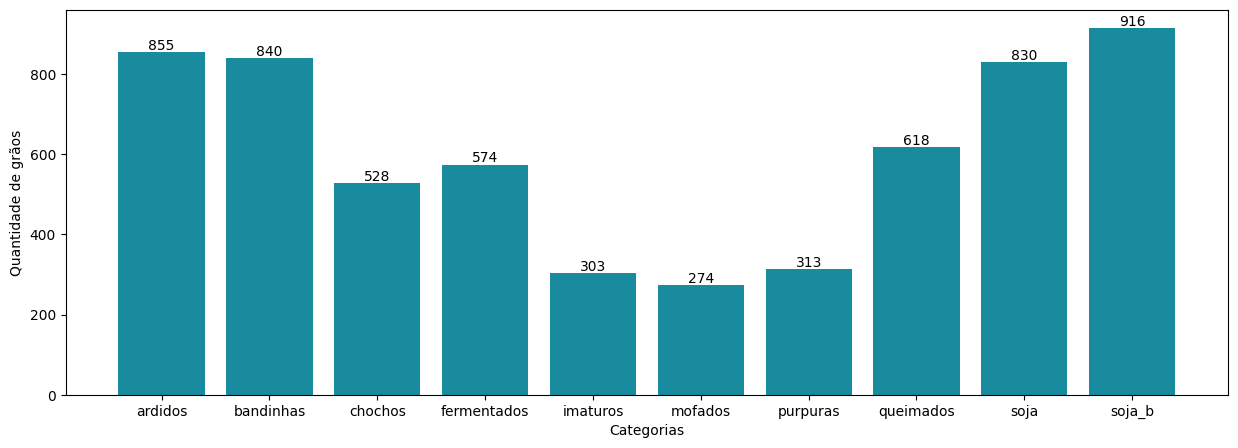

In [13]:
plt.figure(figsize=(15, 5))
labels = qtd_por_categoria.keys()
qtds = qtd_por_categoria.values()
bars = plt.bar(qtd_por_categoria.keys(),
               qtd_por_categoria.values(), color='#188c9e')

plt.xlabel('Categorias')
plt.ylabel('Quantidade de grãos')

for bar, qtd in zip(bars, qtds):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.5, str(qtd),
             ha='center', va='bottom', color='black', fontsize=10)

plt.show()

In [14]:
from sklearn.decomposition import PCA


# Funcao para aplicar o PCA em um conjunto de imagens
def apply_pca(train_images, n_components=LAYER_SIZE):
    # Redimensionar imagens para 2D para aplicar PCA
    # O reshape basicamente aplana as imagens 4D em 2D
    # O train_images chega com a forma (número de imagens, largura, altura, canais) 32x64x64x31
    flat_train_images = train_images.reshape(-1, train_images.shape[-1])
    pca = PCA(n_components=n_components)

    # Fit ajusta o modelo PCA aos dados de treinamento
    # Durante o ajuste, o PCA calcula os componentes principais dos dados
    # Transform transforma os dados de treinamento em componentes principais
    transformed_train_images = pca.fit_transform(flat_train_images)

    # Redimensionar de volta para a forma original com os componentes principais
    # Sera retornado um array 4D de 32x64x64x10
    print(transformed_train_images.shape)
    transformed_train_images = transformed_train_images.reshape(
        train_images.shape[0], train_images.shape[1], train_images.shape[2], n_components)
    print(transformed_train_images.shape)
    return pca, transformed_train_images

In [15]:
def transform_pca(pca, images):
    flat_images = images.reshape(-1, images.shape[-1])
    transformed_images = pca.transform(flat_images)
    transformed_images = transformed_images.reshape(
        images.shape[0], images.shape[1], images.shape[2], -1)
    return transformed_images

In [16]:

# Função para aplicar o PCA em um conjunto de imagens
def preprocess_dataset(ds, pca=None, fit_pca=False):
    images_list = []
    labels_list = []

    # Transforma o dataset em uma lista de imagens e labels
    for images, labels in ds:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())

    # Empilha as imagens e labels
    images = np.concatenate(images_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # Aplica PCA nas imagens
    # Se fit_pca for True, o PCA será ajustado aos dados de treinamento
    # Se pca for fornecido, ele será aplicado às imagens
    if fit_pca:
        pca, images = apply_pca(images)
    elif pca is not None:
        images = transform_pca(pca, images)

    # Transforma as imagens e labels em um dataset do TensorFlow com batches de tamanho BATCH_SIZE
    dataset = tf.data.Dataset.from_tensor_slices(
        (images, labels)).batch(BATCH_SIZE)
    return dataset, pca


train_dataset, pca = preprocess_dataset(train_dataset_original, fit_pca=True)
val_dataset, _ = preprocess_dataset(val_dataset_original, pca=pca)
test_dataset, _ = preprocess_dataset(test_dataset_original, pca=pca)

(17313792, 12)
(4227, 64, 64, 12)


In [17]:
train_dataset, pca = preprocess_dataset(train_dataset_original, fit_pca=True)
val_dataset, _ = preprocess_dataset(val_dataset_original, pca=pca)
test_dataset, _ = preprocess_dataset(test_dataset_original, pca=pca)

(17313792, 12)
(4227, 64, 64, 12)


In [18]:
def compare_pca_image(original, transformed, num_channels=5):
    # Figura 2 linhas e num_channels de colunas
    fig, axs = plt.subplots(2, num_channels, figsize=(10, 5))

    # Para cada canal exibe a imagem transformada (pca) e a original
    for i in range(num_channels):
        img_original = original[..., i]
        axs[0, i].imshow(img_original)
        axs[0, i].axis('off')
        img_transformed = transformed[..., i]
        axs[1, i].imshow(img_transformed)
        axs[1, i].axis('off')

    fig.text(0.5, 0.95, 'Original', ha='center', va='center', fontsize=14)
    fig.text(0.5, 0.48, 'Transformed', ha='center', va='center', fontsize=14)

    plt.tight_layout()  # Ajusta o layout para evitar sobreposição de titulos
    plt.show()

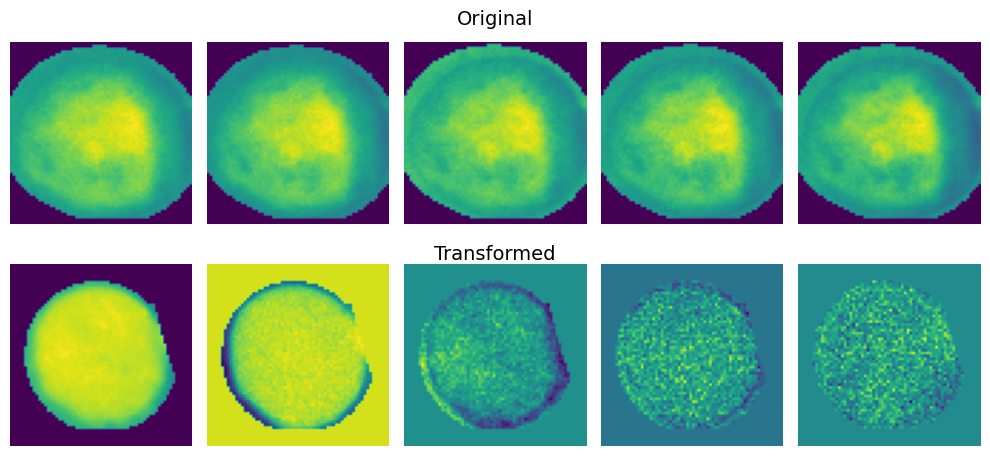

In [19]:
transformed_dataset = train_dataset.take(1)
original_dataset = train_dataset_original.take(1)

transformed_batch_iter = transformed_dataset.as_numpy_iterator()
original_batch_iter = original_dataset.as_numpy_iterator()

transformed_first_batch = next(transformed_batch_iter)
original_first_batch = next(original_batch_iter)

transformed_images, _ = transformed_first_batch
original_images, _ = original_first_batch

# for i in range(len(transformed_images)):
compare_pca_image(original_images[i], transformed_images[i])

In [20]:
# Cache, Shuffle e Prefetch
train_dataset = train_dataset.cache().shuffle(
    1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(
    1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# funcao que mostra todos batch de imagens do dataset
def preview_dataset(dataset):
    batch_count = 0
    for images_batch, labels_batch in dataset:
        print(f'Batch de imagens shape: {images_batch.shape}')
        print(f'Batch de labels shape: {labels_batch.shape}')

        for image, label in zip(images_batch, labels_batch):
            qtd_canais = image.shape[-1]

            print(image.shape)
            print(id_to_label[label.numpy()])

            plt.figure(figsize=(60, 20))
            for i in range(qtd_canais):
                image_to_show = image[..., i]
                plt.subplot(2, 5, i + 1)
                plt.imshow(image_to_show)
                plt.axis('off')
            plt.show()
            break
        break


# preview_dataset(train_dataset)

In [22]:
# altera o tamanho da imagem e normaliza os valores
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# aumenta a quantidade de imagens no dataset atraves de flip e rotacao
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31)
n_classes = len(id_to_label)
print(n_classes)

10


In [23]:
from collections import Counter

def view_classes_of_dataset(dataset):
    classes = []
    for data, label in dataset:
        classes.extend(label.numpy())
    # Realiza a contagem de quantas vezes um número aparece
    # em um vetor e retorna um dicionário com a contagem
    counts = Counter(classes)
    print('Análise do dataset de treino:')
    for key, value in counts.items():
        print(f'\t{key} - {id_to_label[key]}: {value}')

In [24]:
view_classes_of_dataset(train_dataset)
view_classes_of_dataset(val_dataset)
view_classes_of_dataset(test_dataset)

Análise do dataset de treino:
	8 - soja: 579
	0 - ardidos: 589
	9 - soja_b: 622
	2 - chochos: 373
	7 - queimados: 429
	3 - fermentados: 398
	6 - purpuras: 228
	1 - bandinhas: 614
	4 - imaturos: 210
	5 - mofados: 185
Análise do dataset de treino:
	7 - queimados: 102
	9 - soja_b: 154
	0 - ardidos: 136
	2 - chochos: 76
	1 - bandinhas: 115
	8 - soja: 113
	3 - fermentados: 94
	6 - purpuras: 37
	5 - mofados: 34
	4 - imaturos: 35
Análise do dataset de treino:
	0 - ardidos: 133
	7 - queimados: 107
	1 - bandinhas: 148
	5 - mofados: 37
	9 - soja_b: 143
	8 - soja: 121
	4 - imaturos: 39
	2 - chochos: 77
	6 - purpuras: 37
	3 - fermentados: 86


In [25]:
import numpy as np
from sklearn.utils import compute_class_weight

# Extrai os rótulos do dataset de treino
def class_weitghts(train_dataset):
    y_train = []
    X_train = []
    for image_batch, label_batch in train_dataset:
        y_train.extend(label_batch.numpy())
        X_train.extend(image_batch.numpy())

    # Converte para um array NumPy
    y_train = np.array(y_train)
    print(Counter(y_train))

    X_train = np.array(X_train)
    classes = np.unique(y_train)


    class_weights = compute_class_weight(
        class_weight="balanced", classes=classes, y=y_train)
    class_weights_obj = {classes[i]: class_weights[i] for i in range(len(classes))}

    return class_weights_obj

In [26]:
class_weights_obj = class_weitghts(train_dataset)

Counter({9: 622, 1: 614, 0: 589, 8: 579, 7: 429, 3: 398, 2: 373, 6: 228, 4: 210, 5: 185})


In [27]:

from tensorflow.keras import regularizers

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, LAYER_SIZE)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Cria o modelo de rede neural convolucional
# Aplicando camadas de convolução, pooling e densas
# Densas são camadas totalmente conectadas
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    # Camada de saída com softmax para n classes
    layers.Dense(n_classes, activation='softmax')
])


# Compila o modelo aplicando a função de otimização, função de perda e métricas
model.compile(optimizer=optimizer,
              # Função de perda para classificação multiclasse
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])


# model.summary()

# Treina o modelo
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset,
    class_weight=class_weights_obj
)

Epoch 1/1000


/home/duardo/Projects/cellpose/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2990 - loss: 2.0828 - val_accuracy: 0.5603 - val_loss: 1.4038
Epoch 2/1000
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5104 - loss: 1.5766 - val_accuracy: 0.6730 - val_loss: 1.0926
Epoch 3/1000
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6069 - loss: 1.2628 - val_accuracy: 0.7165 - val_loss: 0.9667
Epoch 4/1000
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6660 - loss: 1.1086 - val_accuracy: 0.7489 - val_loss: 0.8662
Epoch 5/1000
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6859 - loss: 1.0264 - val_accuracy: 0.7489 - val_loss: 0.8565
Epoch 6/1000
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7039 - loss: 0.9679 - val_accuracy: 0.7712 - val_loss: 0.7541
Epoch 7/1000
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7297 - loss: 0.9120 - val_accuracy: 0.7679 - val_loss: 0.7442
Epoch 8/1000
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7433 - loss: 0.8514 - val_accuracy:

In [28]:
model_result = model.evaluate(test_dataset)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.1026


In [29]:
print(model_result)

[0.0867815837264061, 0.9870689511299133]


In [30]:
# Banco de dados para salvar os resultados do teste:

import sqlite3

conn = sqlite3.connect('database/results.db')
cur = conn.cursor()

cur.execute(
    '''
        CREATE TABLE IF NOT EXISTS test_results (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            epochs INTEGER,
            accuracy REAL,
            loss REAL,
            qt_train INTEGER,
            qt_val INTEGER,
            qt_test INTEGER,
            data TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            batch INTERGER,
            image_size INTEGER,
            layers INTEGER,
            categories INTEGER,
            class_weight BOOLEAN,
            shuffled_batch BOOLEAN DEFAULT FALSE,
            description VARCHAR(255)

        )
    '''
)

conn.commit()

In [31]:
cur.execute('''
    INSERT INTO test_results (epochs, accuracy, loss, qt_train, qt_val, 
        qt_test, data, image_size, layers, categories, class_weight, shuffled_batch, batch)
    VALUES (?,?,?,?,?,?, datetime('now', 'localtime'), ?, ?, ?, ?, ?, ?)
''',
            (
                EPOCHS,
                model_result[1],
                model_result[0],
                len(train_dataset),
                len(val_dataset),
                len(test_dataset),
                IMAGE_SIZE,
                LAYER_SIZE,
                len(id_to_label),
                1,
                1,
                BATCH_SIZE
            )
            )

conn.commit()
conn.close()

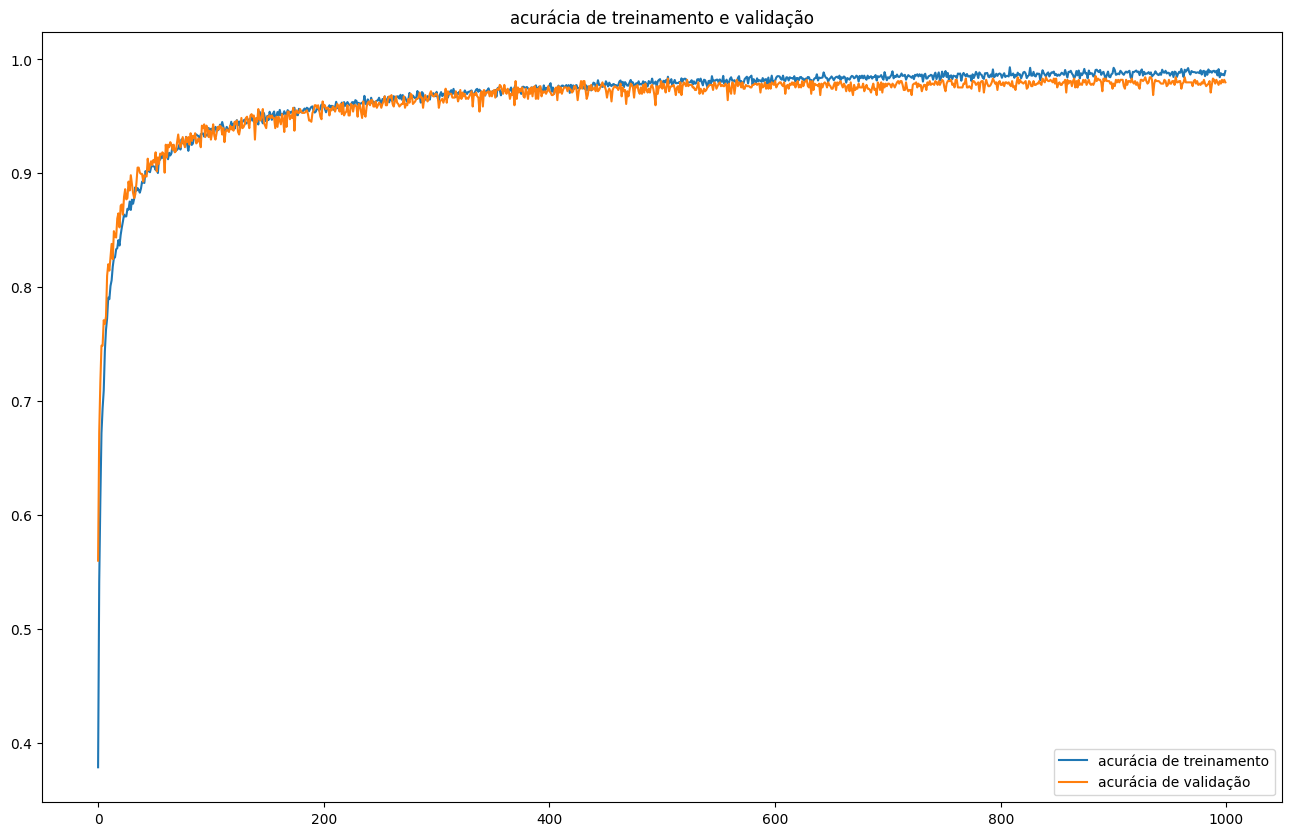

In [32]:
history.params
history.history['accuracy']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(16,10))
plt.subplot(1, 1, 1)
plt.plot(range(EPOCHS), acc, label='acurácia de treinamento')
plt.plot(range(EPOCHS), val_acc, label='acurácia de validação')
plt.legend(loc='lower right')
plt.title('acurácia de treinamento e validação')
plt.savefig('accuracy_1000_epochs.png')

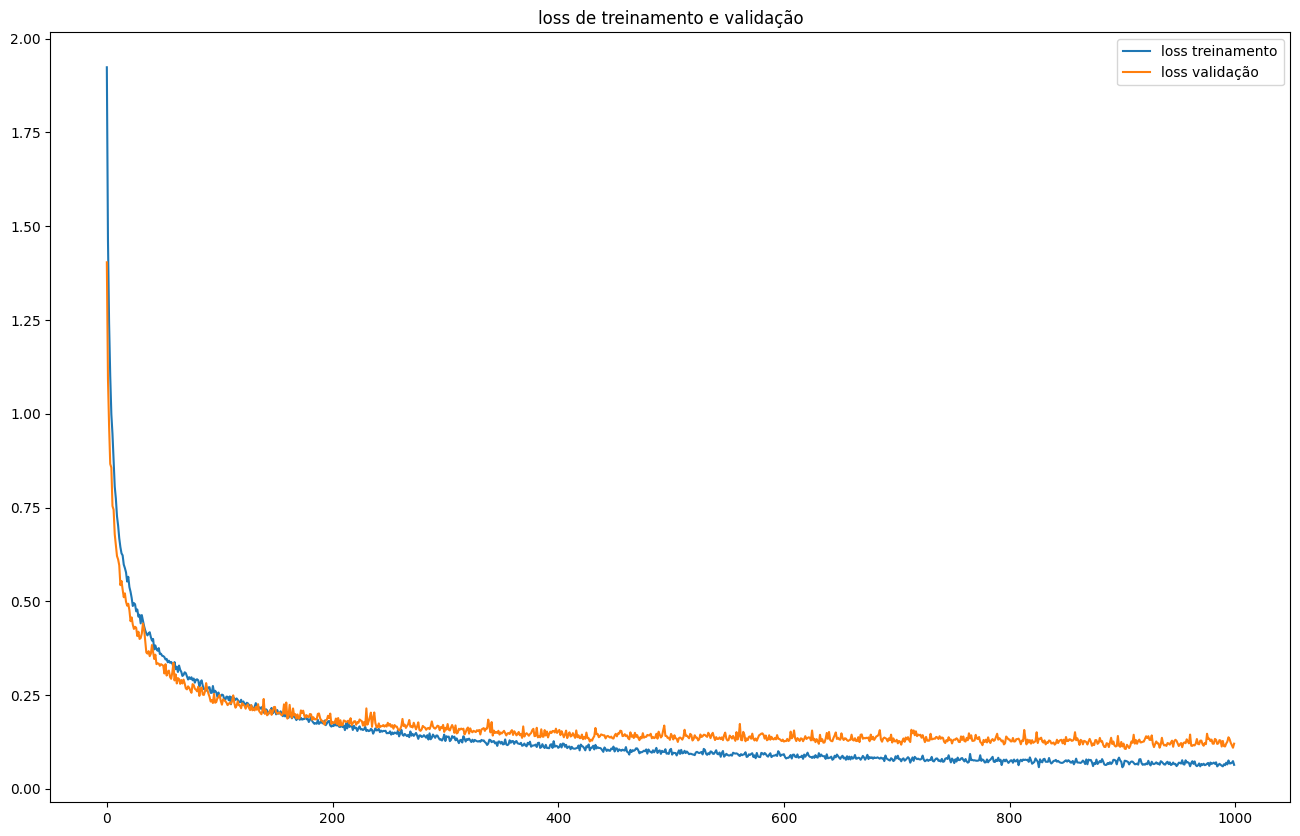

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(16,10))
plt.subplot(1, 1, 1)
plt.plot(range(EPOCHS), loss, label='loss treinamento')
plt.plot(range(EPOCHS), val_loss, label='loss validação')
plt.legend(loc='upper right')
plt.title('loss de treinamento e validação')
plt.savefig('loss_1000_epochs.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


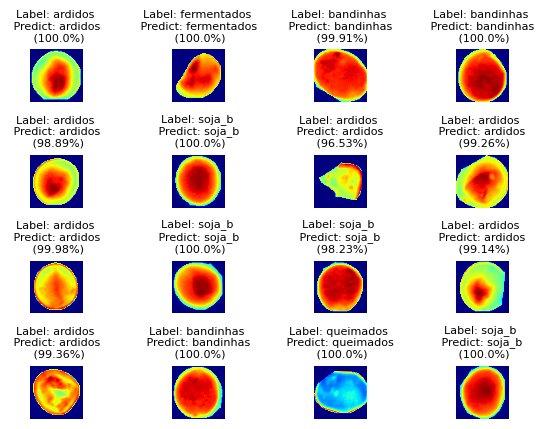

In [34]:
test_dataset = test_dataset.shuffle(buffer_size=1000)
for images_batch, labels_batch in test_dataset.take(1):
    for i in range(len(images_batch)):
        plt.subplots_adjust(hspace=1, wspace=1)
        image = images_batch[i]
        label = labels_batch[i]

        im_to_show = image[..., 0]
        batch_predict = model.predict(images_batch)

        best_predict = np.argmax(batch_predict[i])
        confidence = round(100 * (np.max(batch_predict[i])), 2)

        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(im_to_show, cmap='jet')
        plt.axis('off')
        plt.title(f'Label: {id_to_label[label.numpy()]} \n Predict: {
                  id_to_label[best_predict]} \n ({confidence}%)', fontsize=8)

In [35]:
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_dataset:
    batch_predict = model.predict(images_batch)
    best_predict = np.argmax(batch_predict, axis=1)

    true_labels.extend(labels_batch.numpy())
    predicted_labels.extend(best_predict)

    # print(best_predict)
    # print(labels_batch.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [36]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       133
           1       1.00      1.00      1.00       148
           2       0.99      0.97      0.98        77
           3       0.98      0.98      0.98        86
           4       0.97      1.00      0.99        39
           5       0.92      0.97      0.95        37
           6       1.00      1.00      1.00        37
           7       0.99      0.99      0.99       107
           8       1.00      0.99      1.00       121
           9       0.99      0.99      0.99       143

    accuracy                           0.99       928
   macro avg       0.98      0.99      0.98       928
weighted avg       0.99      0.99      0.99       928



- **Precisão** = TP / (TP + FP)

- **Recall** = TP / (TP + FN)

- **F1 Score** = 2 _ (Precisão _ Recall) / (Precisão + Recall)


In [37]:
view_classes_of_dataset(test_dataset)

Análise do dataset de treino:
	2 - chochos: 77
	1 - bandinhas: 148
	0 - ardidos: 133
	9 - soja_b: 143
	5 - mofados: 37
	7 - queimados: 107
	8 - soja: 121
	3 - fermentados: 86
	4 - imaturos: 39
	6 - purpuras: 37


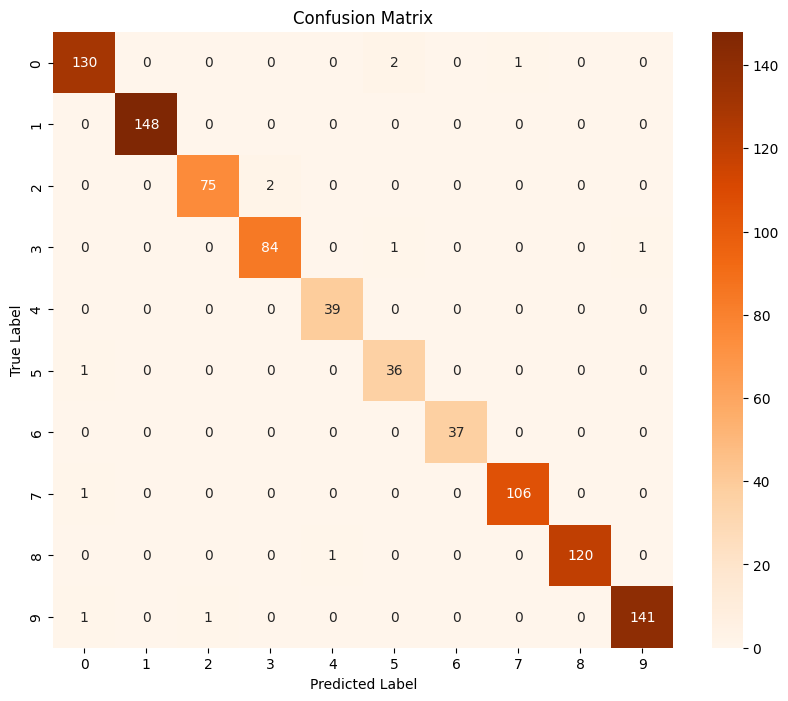

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,476,544 (9.45 MB)

 Trainable params: 825,514 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,651,030 (6.30 MB)

/home/duardo/Projects/cellpose/.venv/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


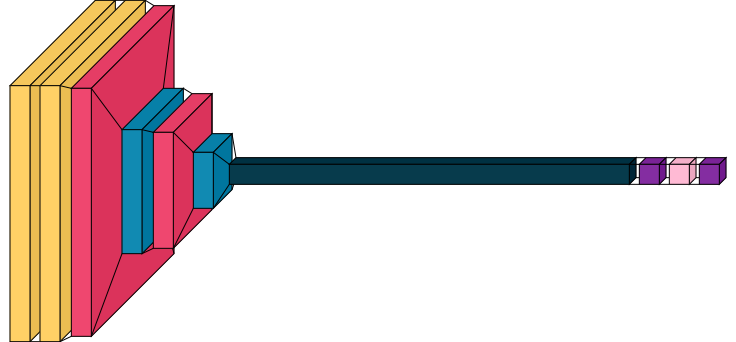

In [39]:
import visualkeras

model.summary()

visualkeras.layered_view(
    model,
)


In [40]:
model.save(f"models/model_{str(datetime.datetime.now())}.keras")